In [43]:
import pandas as pd

In [44]:
import numpy as np

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

## First, Load the data into a Pandas DataFrame

In [46]:
df=pd.read_csv('train.csv',index_col=0)

In [47]:
df.shape

(576, 5)

In [48]:
df.head()


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


## Reset the column names for convenience

In [49]:
df.columns

Index(['Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')

In [50]:
df.columns=['MSLD','ND','TVD','MSFD','MD2007']

In [51]:
df.head()

,MSLD,ND,TVD,MSFD,MD2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


## Check correlation correlation coefficient between variables
Find 1.0 correlation between 'Number of Donation' and 'Total Volumn Donated', which means the volumn donated each time is fixed. Multicolinearity is detected between 'ND' and 'TVD'. As a result, we will only use one of them in the linear models to do prediction. If both of them are included, the estimated regression coefficient of the two variables will be highly dependent on each other. Also, the precision of the regression coefficients will decrease.

'Total Volumn Donated' also has weak positive correlation with 'Month since First Donation', which make sense that the longer a donor participates in the program the more he or she donates. A scatter plot is drawn to show the correlation.

In [52]:
df.corr()

,MSLD,ND,TVD,MSFD,MD2007
MSLD,1.000000,-0.159731,-0.159731,0.186899,-0.261234
ND,-0.159731,1.000000,1.000000,0.622116,0.220615
TVD,-0.159731,1.000000,1.000000,0.622116,0.220615
MSFD,0.186899,0.622116,0.622116,1.000000,-0.019819
MD2007,-0.261234,0.220615,0.220615,-0.019819,1.000000


There is multicolineartiy between 'Number of Donations' and 'Total Volumn Donated'

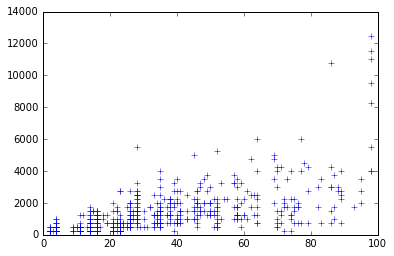

In [53]:
plt.plot(df.MSFD,df.TVD,'+')

## Histograms and Boxplots of independent variables

From histograms we conclude that he independent variables are not normally distributed.

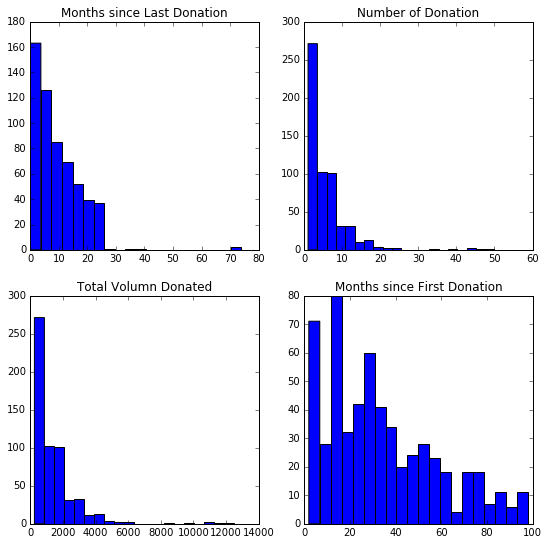

In [54]:
fig, ax = plt.subplots(2,2,figsize=(9,9))

ax[0,0].hist(df.MSLD,bins=20)
ax[0,0].set_title('Months since Last Donation')

ax[0,1].hist(df.ND,bins=20)
ax[0,1].set_title('Number of Donation')

ax[1,0].hist(df.TVD,bins=20)
ax[1,0].set_title('Total Volumn Donated')

ax[1,1].hist(df.MSFD,bins=20)
ax[1,1].set_title('Months since First Donation')

Here we use QQ-plot to evaluate the normality of the data distribution. Results show that only the variable 'Months since Last Donation' is relatively normally distributed, with R^2 = 0.9325

In [55]:
import scipy.stats as stats

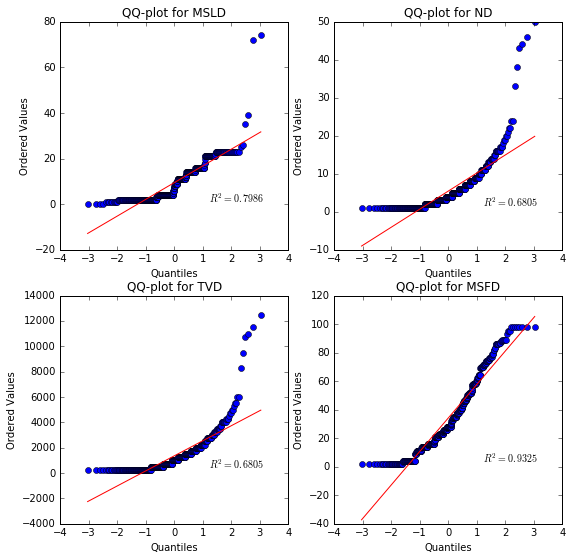

In [56]:
fig, ax = plt.subplots(2,2,figsize=(9,9))
graph = stats.probplot(df.MSLD,dist='norm',plot=ax[0,0])
graph = stats.probplot(df.ND,dist='norm',plot=ax[0,1])
graph = stats.probplot(df.TVD,dist='norm',plot=ax[1,0])
graph = stats.probplot(df.MSFD,dist='norm',plot=ax[1,1])
ax[0,0].set_title('QQ-plot for MSLD')
ax[0,1].set_title('QQ-plot for ND')
ax[1,0].set_title('QQ-plot for TVD')
ax[1,1].set_title('QQ-plot for MSFD')

As one of the assumptions to do linear regression is multivariate normality, we need to fix the left skewness of the variates, including 'MSLD', 'ND', 'TVD'. The technique to apply here is the BoxCox transformation. 
Here we first do it on 'MSLD', the QQ-plot after transformation shows great improvement in R^2.

In [57]:
from scipy import stats

The lambda is 0.286760575186


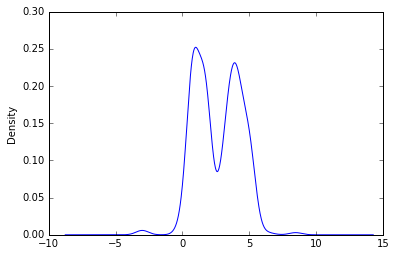

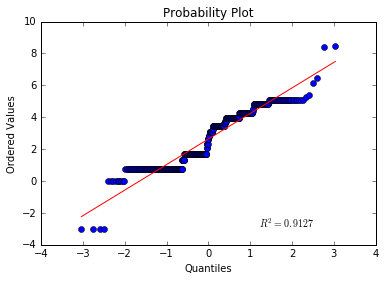

In [58]:
df['BC_MSLD'] = df.MSLD
for i in df.index:
    df.loc[i,'BC_MSLD'] += 0.001

values = stats.boxcox(df['BC_MSLD'].values)[0]
lambdaa = stats.boxcox(df['BC_MSLD'].values)[1]
df['BC_MSLD']=values    
    
df['BC_MSLD'].plot(kind='density')

plt.figure()
graph = stats.probplot(df['BC_MSLD'],dist='norm',plot=plt)
print("The lambda is %s" % str(lambdaa))

The same technique is applied to varable 'ND' to make the data normalized.

The lambda is -0.0561993919615


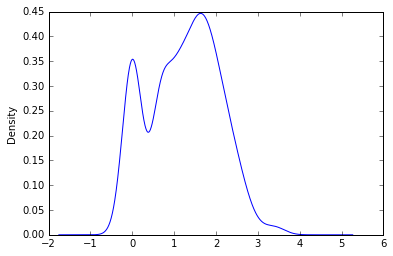

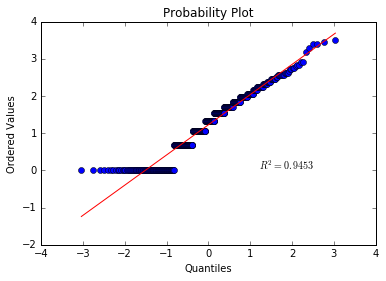

In [68]:
df['BC_ND'] = df.ND
for i in df.index:
    df.loc[i,'BC_ND'] += 0.001

values = stats.boxcox(df['BC_ND'].values)[0]
lambdaa1 = stats.boxcox(df['BC_ND'].values)[1]
df['BC_ND']=values    
    
df['BC_ND'].plot(kind='density')

plt.figure()
graph = stats.probplot(df['BC_ND'],dist='norm',plot=plt)
print("The lambda is %s" % str(lambdaa1))

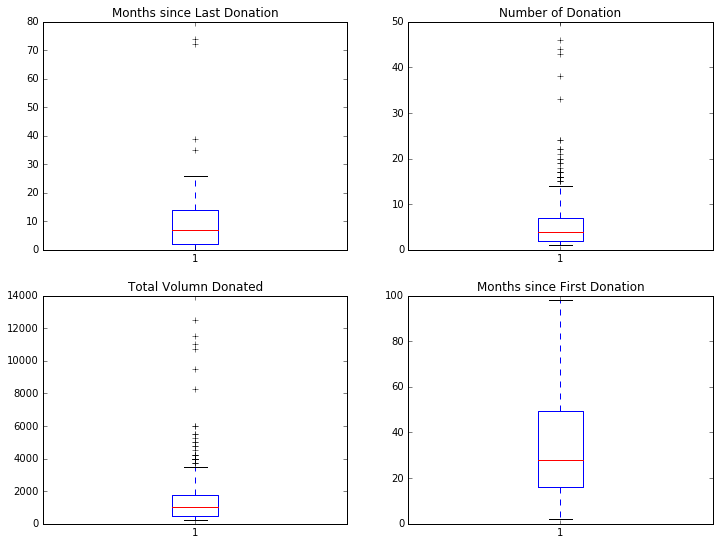

In [59]:
fig,ax=plt.subplots(2,2,figsize=(12,9))
ax[0,0].boxplot(df.MSLD)
ax[0,0].set_title('Months since Last Donation')
ax[0,1].boxplot(df.ND)
ax[0,1].set_title('Number of Donation')
ax[1,0].boxplot(df.TVD)
ax[1,0].set_title('Total Volumn Donated')
ax[1,1].boxplot(df.MSFD)
ax[1,1].set_title('Months since First Donation')

After dropping missing values size of the data does not change. It means there is no missing valus in the data

In [60]:
df= df.dropna()

In [61]:
df.shape

(576, 6)

## We will do a brief investigation on the train data as well. The goal is to see if the test data and train data are similarly distributed

The histogram and QQ-plot tell us that the distribution of test data is closer to normal distribution than the train data, yet not close enough.

In [62]:
df_test = pd.read_csv('test.csv',index_col = 0)

In [63]:
df_test.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
659,2,12,3000,52
276,21,7,1750,38
263,4,1,250,4
303,11,11,2750,38
83,4,12,3000,34


In [64]:
df_test.columns=['MSLD','ND','TVD','MSFD']

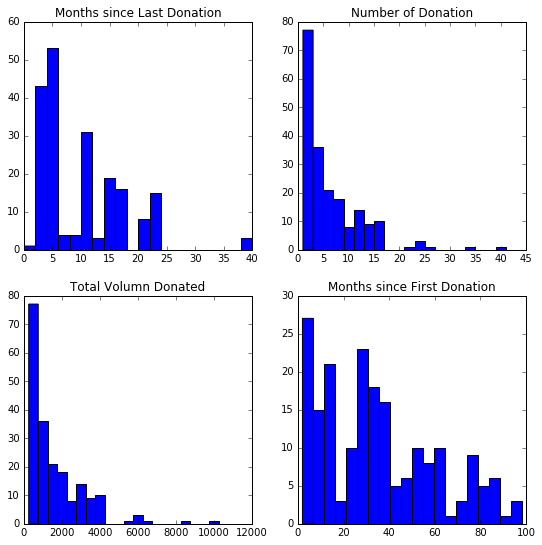

In [65]:
fig, ax = plt.subplots(2,2,figsize=(9,9))

ax[0,0].hist(df_test.MSLD,bins=20)
ax[0,0].set_title('Months since Last Donation')

ax[0,1].hist(df_test.ND,bins=20)
ax[0,1].set_title('Number of Donation')

ax[1,0].hist(df_test.TVD,bins=20)
ax[1,0].set_title('Total Volumn Donated')

ax[1,1].hist(df_test.MSFD,bins=20)
ax[1,1].set_title('Months since First Donation')

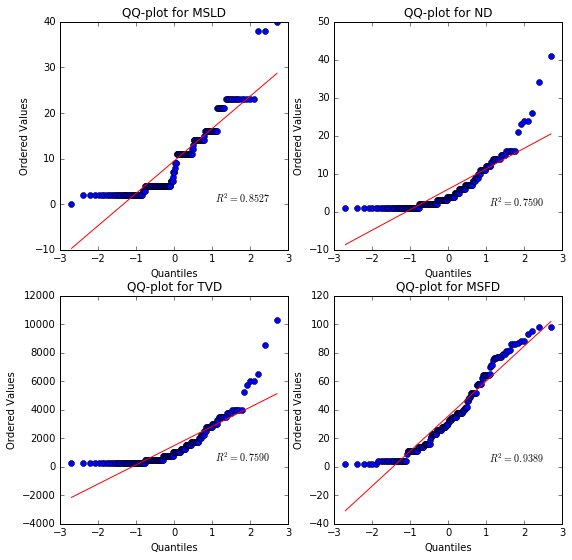

In [66]:
fig, ax = plt.subplots(2,2,figsize=(9,9))
graph = stats.probplot(df_test.MSLD,dist='norm',plot=ax[0,0])
graph = stats.probplot(df_test.ND,dist='norm',plot=ax[0,1])
graph = stats.probplot(df_test.TVD,dist='norm',plot=ax[1,0])
graph = stats.probplot(df_test.MSFD,dist='norm',plot=ax[1,1])
ax[0,0].set_title('QQ-plot for MSLD')
ax[0,1].set_title('QQ-plot for ND')
ax[1,0].set_title('QQ-plot for TVD')
ax[1,1].set_title('QQ-plot for MSFD')

## In the next part, we are going to apply the multi linear regression model on the train dataset to see if we are able to achieve a good fit

In [70]:
import statsmodels.formula.api as smf

In [71]:
df.head()

,MSLD,ND,TVD,MSFD,MD2007,BC_MSLD,BC_ND
619,2,50,12500,98,1,0.767445,3.511860
664,0,13,3250,28,1,-3.006170,2.388721
441,1,16,4000,35,1,0.001000,2.567428
160,2,20,5000,45,1,0.767445,2.757172
358,1,24,6000,77,0,0.001000,2.910449


In [72]:
lm = smf.ols(formula = 'MD2007 ~ BC_MSLD + BC_ND + MSFD',data = df).fit()

In [73]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MD2007   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     31.37
Date:                Thu, 21 Jul 2016   Prob (F-statistic):           8.75e-19
Time:                        11:53:22   Log-Likelihood:                -283.05
No. Observations:                 576   AIC:                             574.1
Df Residuals:                     572   BIC:                             591.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2571      0.043      5.948      0.000         0.172     0.342
BC_MSLD       -0.0406      0.011     -3.625      0.000        -0.063    -0.019
BC_ND          0.1965      0.030      6.481      0.000         0.137     0.256
MSFD          -0.0044      0.001     -4.270      0.000        -0.006    -0.002
==============================================================================
Omnibus:                       72.467   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.085
Skew:                           0.963   Prob(JB):                     6.12e-21
Kurtosis:                       2.590   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The interpretation: The R-square for the regression is 0.141, which means only 14% of the variance of "MD2007" variable is explained by the predictor variables. It means the model does not work well.
Although the model is not good enough, we can still see that the correlation coefficient of variable "Number of Donation" is 0.1965, which means a donor's past donation records has positive correlation with his or her possibility to donate in March 2007.

In the table, the null hypothesis is the corelation coefficient equals 0. The alternative hypothesis is that the correlation coefficient does not equal 0.
As the P value is smaller than 0.001, we can safely reject the null hypothesis in favor of the alternative hypothesis.

### Here in the case, the predictors are already transformed by BoxCox method!

### Based on the R-squared of 0.141, I conclude that the linear model does not well describe the relationship between "Made donation in March 2007" and all the predictor variables. The reason is that the outcome variable is a binary variable. It's not suitable to apply linear model in the analysis.

## Prediction

First of all, we will check if the data is imbalanced towards people who do not donate. The result shows that most people in the datasets did not donate in March 2007. This may cause deficiency in our prediction.

In [106]:
df.MD2007.value_counts()

0    438
1    138
Name: MD2007, dtype: int64

Instead of linear regression models, we will apply logistic regression to predict test-donation on the test datasets..

In [74]:
import statsmodels.api as sm

In [75]:
X_sm = sm.add_constant(df[['MSLD','ND','MSFD']])

In [77]:
clf = sm.Logit(df.MD2007,X_sm).fit()

Optimization terminated successfully.
         Current function value: 0.483168
         Iterations 6


In [78]:
clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 MD2007   No. Observations:                  576
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Jul 2016   Pseudo R-squ.:                  0.1225
Time:                        14:47:14   Log-Likelihood:                -278.30
converged:                       True   LL-Null:                       -317.15
                                        LLR p-value:                 9.648e-17
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.5856      0.202     -2.902      0.004        -0.981    -0.190
MSLD          -0.0910      0.019     -4.802      0.000        -0.128    -0.054
ND             0.1299      0.029      4.464      0.000         0.073     0.187
MSFD          -0.0188      0.007     -2.853      0.004        -0.032    -0.006
==============================================================================
"""

In [79]:
from sklearn.linear_model import LogisticRegression

In [81]:
from sklearn.metrics import confusion_matrix

In [82]:
model = LogisticRegression()

In [83]:
model.fit(X_sm, df.MD2007)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
model.score(X_sm, df.MD2007)

0.76388888888888884

This means the model successfully predict 76.3% of the test data sets. We will then use confusion matrix to further validate the model.

In [89]:
y_hat = model.predict(X_sm)

In [90]:
confusion_matrix(df.MD2007,y_hat)

array([[425,  13],
       [123,  15]])

The result shows our model is doing well in subjects who did not donate in March 2007 with 97% accuracy. But it miss-predict 89% of the people who did donate blood. Although the overall accuracy is 76.4%, it still needs to be improved.

Next, we will try to only use 'MSLD' - months since last donation and 'ND' - number of donation to do the prediction. The result shows slight improvement in predicting negative response (people who do not donate), but not in positive (people who do donate). It is due to the fact that the data is imbalanced that most people in the datasets did not donate in March 2007.

In [91]:
X_sm1 = sm.add_constant(df[['MSLD','ND']])

In [92]:
model = LogisticRegression()

In [93]:
model.fit(X_sm1, df.MD2007)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
y_hat1 = model.predict(X_sm1)

In [95]:
confusion_matrix(df.MD2007,y_hat1)

array([[429,   9],
       [124,  14]])

Our next thing to try is the GridSearch method. we import 4 different parameters and put a CV value of 5. However, the result does not show improvement, neither. Since this model gives the best overall accuracy, we will use it for submission.

In [111]:
from sklearn.grid_search import GridSearchCV

In [112]:
model_G = LogisticRegression()
parameters = {'solver': ['newton-cg','lbfgs','liblinear','sag']}

clf = GridSearchCV(model_G, parameters, cv = 5)

clf.fit(X_sm1, df.MD2007)

//anaconda/envs/gads/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/gads/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/gads/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/gads/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/gads/lib/python3.5/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached w

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [113]:
y_hat2 = clf.predict(X_sm1)

In [114]:
confusion_matrix(df.MD2007,y_hat2)

array([[429,   9],
       [124,  14]])

### Here we will apply the model on test datasets.

In [116]:
x_test = sm.add_constant(df_test[['MSLD','ND']])

In [117]:
y_hat_test = clf.predict(x_test)

In [118]:
y_hat_test

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [120]:
pd.DataFrame(y_hat_test).to_csv('BloodDonationSubmissionFormat.csv')

The next try is to use the “balanced” mode to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). The result shows dramatic improvement in predicting people who donate but decrease in accuracy in predicting people who do not donate. This result in an overall accuracy of 60%.

In [107]:
model = LogisticRegression(class_weight = 'balanced')

In [108]:
model.fit(X_sm1, df.MD2007)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [109]:
y_hat3= model.predict(X_sm1)

In [110]:
confusion_matrix(df.MD2007, y_hat3)

array([[241, 197],
       [ 29, 109]])